In [1]:
import os 
import glob
from pathlib import Path
import pandas as pd 
import numpy as np 
import nibabel as nib 
import json


/working/lupolab/julia/anaconda/envs/pytnew/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


## We need to map the segmentations that are named by the T2-FLAIR image to their corresponding patient: 

Begin by reading in the json file and data frames that describe what we just segmented: 

In [2]:
PATH = Path('/working/lupolab/julia/tcia_analysis/datasets/')

In [3]:
df = pd.read_csv(Path(PATH, 'one_exam_per_patient_with_fixed_vol.csv'))

In [12]:
with open(Path(PATH.parent,'nvidia', 'config', 'config_datalist_t1c.json'), 'r') as f: 
    segment_json = json.load(f)

In [13]:
segment_json

{'training': [],
 'validation': [{'image': 'TCGA-GBM-nifti/TCGA-06-0240/07-02-2005-04728/9-AxT1-thin_for_surgery-27598.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-06-0143/02-11-2005-83875/11-COR__T1_POST_GD_FLAIR-28783.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-06-0149/03-25-2003-87536/10-COR_T1_POST_GD_FLAIR-88922.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-19-0955/04-07-2001-NR_MRI_BRAIN_WWO-83151/8-MRHG_T1_AX_POST_GAD-01973.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-06-0648/01-20-2006-51419/11-AX_T1_POST_GD_FLAIR-02197.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-12-0829/06-02-1999-BRAIN-09460/18-T1_AX_POST-73832.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-06-0171/08-04-2001-68007/9-AX_T1_POST_GD_FLAIR-32350.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-14-1401/04-18-1997-MRI_BRAIN_W_WOUT_CONTRAST-27628/1201-BRAIN_WWO_T1_POST-04167.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-02-0033/05-26-1997-MRI_BRAIN_WWO_CONTR-89744/6-AX_T1_POST-51465.nii.gz'},
  {'image': 'TCGA-GBM-nifti/TCGA-19-1390/03-

Now list all of the segmentations that are in our 'eval' folder: 

In [14]:
segmentations = os.listdir(Path(PATH.parent, 'nvidia', 'eval_t1c'))

In [15]:
len(segmentations)

230

In [16]:
df.head()

,patient_id,cohort,patient_exam,image,contrast,contrast_label,plane,exam_eligible,fixed_vol
0,TCGA-06-0240,TCGA-GBM,07-02-2005-04728,9-AxT1-thin_for_surgery-27598,1,T1C,ax,1,4-AxFLAIR-thin_for_surgery-47036
1,TCGA-06-0240,TCGA-GBM,07-02-2005-04728,21-nordicICE_HFH_-_rBF_map_-Leakage_corrected-...,1,rBF,cor,1,4-AxFLAIR-thin_for_surgery-47036
2,TCGA-06-0240,TCGA-GBM,07-02-2005-04728,1-3_PLANE_LOC-22369,0,LOCALIZER,NaN,1,4-AxFLAIR-thin_for_surgery-47036
3,TCGA-06-0240,TCGA-GBM,07-02-2005-04728,5-AXIAL_DIFFUSION-62807,0,DWI,ax,1,4-AxFLAIR-thin_for_surgery-47036
4,TCGA-06-0240,TCGA-GBM,07-02-2005-04728,8-AXIAL_PERFUSION-44568,1,PERFUSION,ax,1,4-AxFLAIR-thin_for_surgery-47036


In [19]:
df.shape

(3630, 9)

In [20]:
df_nodup = df.drop_duplicates(subset=['patient_id'])
df_nodup = df_nodup.drop(['image', 'contrast', 'contrast_label', 'plane', 'exam_eligible', 'fixed_vol'], axis = 1)

In [21]:
df_nodup.shape

(274, 3)

In [22]:
df_nodup = df_nodup.reset_index(drop = True)

In [23]:
df_nodup.head()

,patient_id,cohort,patient_exam
0,TCGA-06-0240,TCGA-GBM,07-02-2005-04728
1,TCGA-06-0143,TCGA-GBM,02-11-2005-83875
2,TCGA-06-0149,TCGA-GBM,03-25-2003-87536
3,TCGA-19-0955,TCGA-GBM,04-07-2001-NR_MRI_BRAIN_WWO-83151
4,TCGA-06-0648,TCGA-GBM,01-20-2006-51419


In [50]:
seg_loc_root = Path(PATH.parent, 'nvidia', 'eval_t1c')

In [51]:
seg_list = [x['image'] for x in segment_json['validation']]

In [52]:
seg_list

['TCGA-GBM-nifti/TCGA-06-0240/07-02-2005-04728/9-AxT1-thin_for_surgery-27598.nii.gz',
 'TCGA-GBM-nifti/TCGA-06-0143/02-11-2005-83875/11-COR__T1_POST_GD_FLAIR-28783.nii.gz',
 'TCGA-GBM-nifti/TCGA-06-0149/03-25-2003-87536/10-COR_T1_POST_GD_FLAIR-88922.nii.gz',
 'TCGA-GBM-nifti/TCGA-19-0955/04-07-2001-NR_MRI_BRAIN_WWO-83151/8-MRHG_T1_AX_POST_GAD-01973.nii.gz',
 'TCGA-GBM-nifti/TCGA-06-0648/01-20-2006-51419/11-AX_T1_POST_GD_FLAIR-02197.nii.gz',
 'TCGA-GBM-nifti/TCGA-12-0829/06-02-1999-BRAIN-09460/18-T1_AX_POST-73832.nii.gz',
 'TCGA-GBM-nifti/TCGA-06-0171/08-04-2001-68007/9-AX_T1_POST_GD_FLAIR-32350.nii.gz',
 'TCGA-GBM-nifti/TCGA-14-1401/04-18-1997-MRI_BRAIN_W_WOUT_CONTRAST-27628/1201-BRAIN_WWO_T1_POST-04167.nii.gz',
 'TCGA-GBM-nifti/TCGA-02-0033/05-26-1997-MRI_BRAIN_WWO_CONTR-89744/6-AX_T1_POST-51465.nii.gz',
 'TCGA-GBM-nifti/TCGA-19-1390/03-20-2001-NR_MRI_BRAIN_WWO-90326/8-MP_RAGE_AXIAL-23748.nii.gz',
 'TCGA-GBM-nifti/TCGA-08-0356/03-26-2002-MSTEALTH-31923/7-AX_3D_SPGR_GAD-17095.nii.gz',


In [53]:
attempted_segmentations = pd.DataFrame({'patient_id': [x.split('/')[1] for x in seg_list], 
                                        
             'seg_loc': [x.split('/')[3].split('.')[-3] for x in seg_list], 
             'seg_file': [ x.split('/')[3].split('.')[-3]+'_TC.nii.gz' for x in seg_list]})

In [54]:
actual_segmentations = pd.DataFrame(segmentations)

In [55]:
actual_segmentations.shape, attempted_segmentations.shape

((230, 1), (232, 3))

In [56]:
actual_segmentations.head()

,0
0,1001-T1_SAG_POST-76764
1,9-AXIAL_T1_POST_GD-55381
2,10-COR_T1_POST_GD_FLAIR-88922
3,9-AXIAL_T1_POST_GD-12653
4,8-T1_AX_POST_GAD-12257


In [57]:
attempted_segmentations.head()

,patient_id,seg_loc,seg_file
0,TCGA-06-0240,9-AxT1-thin_for_surgery-27598,9-AxT1-thin_for_surgery-27598_TC.nii.gz
1,TCGA-06-0143,11-COR__T1_POST_GD_FLAIR-28783,11-COR__T1_POST_GD_FLAIR-28783_TC.nii.gz
2,TCGA-06-0149,10-COR_T1_POST_GD_FLAIR-88922,10-COR_T1_POST_GD_FLAIR-88922_TC.nii.gz
3,TCGA-19-0955,8-MRHG_T1_AX_POST_GAD-01973,8-MRHG_T1_AX_POST_GAD-01973_TC.nii.gz
4,TCGA-06-0648,11-AX_T1_POST_GD_FLAIR-02197,11-AX_T1_POST_GD_FLAIR-02197_TC.nii.gz


In [58]:
actual_seg_map = attempted_segmentations.loc[attempted_segmentations.seg_loc.isin(list(actual_segmentations[0]))]

In [59]:
actual_seg_map.shape

(227, 3)

In [60]:
actual_seg_map.head()

,patient_id,seg_loc,seg_file
0,TCGA-06-0240,9-AxT1-thin_for_surgery-27598,9-AxT1-thin_for_surgery-27598_TC.nii.gz
1,TCGA-06-0143,11-COR__T1_POST_GD_FLAIR-28783,11-COR__T1_POST_GD_FLAIR-28783_TC.nii.gz
2,TCGA-06-0149,10-COR_T1_POST_GD_FLAIR-88922,10-COR_T1_POST_GD_FLAIR-88922_TC.nii.gz
3,TCGA-19-0955,8-MRHG_T1_AX_POST_GAD-01973,8-MRHG_T1_AX_POST_GAD-01973_TC.nii.gz
4,TCGA-06-0648,11-AX_T1_POST_GD_FLAIR-02197,11-AX_T1_POST_GD_FLAIR-02197_TC.nii.gz


In [61]:
seg_df = pd.merge(actual_seg_map, df_nodup, how = 'left', on = 'patient_id')

In [62]:
seg_loc_root

PosixPath('/working/lupolab/julia/tcia_analysis/nvidia/eval_t1c')

In [63]:
seg_df['seg_loc'] = [str(Path(seg_loc_root, x)) for x in list(seg_df['seg_loc'])]

In [64]:
seg_df.head()

,patient_id,seg_loc,seg_file,cohort,patient_exam
0,TCGA-06-0240,/working/lupolab/julia/tcia_analysis/nvidia/ev...,9-AxT1-thin_for_surgery-27598_TC.nii.gz,TCGA-GBM,07-02-2005-04728
1,TCGA-06-0143,/working/lupolab/julia/tcia_analysis/nvidia/ev...,11-COR__T1_POST_GD_FLAIR-28783_TC.nii.gz,TCGA-GBM,02-11-2005-83875
2,TCGA-06-0149,/working/lupolab/julia/tcia_analysis/nvidia/ev...,10-COR_T1_POST_GD_FLAIR-88922_TC.nii.gz,TCGA-GBM,03-25-2003-87536
3,TCGA-19-0955,/working/lupolab/julia/tcia_analysis/nvidia/ev...,8-MRHG_T1_AX_POST_GAD-01973_TC.nii.gz,TCGA-GBM,04-07-2001-NR_MRI_BRAIN_WWO-83151
4,TCGA-06-0648,/working/lupolab/julia/tcia_analysis/nvidia/ev...,11-AX_T1_POST_GD_FLAIR-02197_TC.nii.gz,TCGA-GBM,01-20-2006-51419


In [65]:
seg_df.to_csv(Path(PATH, 'segmentation_df.csv'), index = False)

In [66]:
os.listdir(PATH)

['TCGA-GBM-nifti',
 '.ipynb_checkpoints',
 'images_with_dicom_contrast.csv',
 'one_exam_per_patient_with_fixed_vol.csv',
 'manifest_files',
 'one_exam_per_patient_with_labels_flair.csv',
 'tcga_subtype_data.csv',
 'dicom_images_with_contrast.csv',
 'contrast_labels_with_flair_eligibility.csv',
 'exam_counts.txt',
 'one_exam_per_patient_with_labels.csv',
 'contrast_labels.csv',
 'come_back_to',
 'segmentation_df.csv',
 'rename_script.sh',
 'exam_counts.csv',
 'contrast_labels_with_eligibility.csv',
 'TCGA-LGG-nifti']

## Now just quickly visually spot checking a few of the segmentations to see if they are correct: 

In [136]:
## Let's investigate just a few of them to ensure that they are correct: 
import nibabel as nib
import matplotlib.pyplot as plt

In [137]:
%matplotlib inline

### TCGA-06-0648



In [138]:
row = seg_df.iloc[4]
print(row['patient_id'])

TCGA-06-0648


In [139]:
seg_file = row['seg_file']

In [140]:
seg_file

'11-AX_T1_POST_GD_FLAIR-02197_TC.nii.gz'

In [141]:
'_'.join(row['seg_file'].split("_")[:-1])

'11-AX_T1_POST_GD_FLAIR-02197'

In [142]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [143]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)
t2all_vol.any()

True

In [144]:
fla_vol.shape[2]/2

88.5

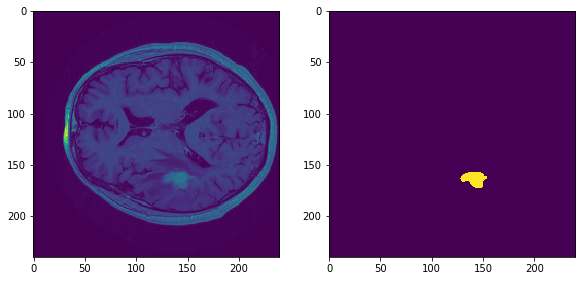

In [145]:
x = 88
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])

### TCGA-06-0171



In [146]:
row = seg_df.iloc[6]
print(row['patient_id'])

TCGA-06-0171


In [147]:
seg_file = row['seg_file']

In [148]:
seg_file

'9-AX_T1_POST_GD_FLAIR-32350_TC.nii.gz'

In [149]:
'_'.join(row['seg_file'].split("_")[:-1])

'9-AX_T1_POST_GD_FLAIR-32350'

In [158]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [159]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)
t2all_vol.any()

True

In [160]:
fla_vol.shape[2]/2

73.5

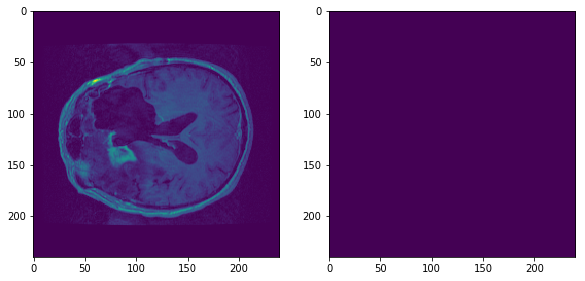

In [161]:
x = 90
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])

### TCGA-06-0143



In [162]:
row = seg_df.iloc[1]
print(row['patient_id'])

TCGA-06-0143


In [163]:
seg_file = row['seg_file']

In [164]:
seg_file

'11-COR__T1_POST_GD_FLAIR-28783_TC.nii.gz'

In [165]:
'_'.join(row['seg_file'].split("_")[:-1])

'11-COR__T1_POST_GD_FLAIR-28783'

In [166]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [167]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)
t2all_vol.any()

True

In [168]:
fla_vol.shape[2]/2

90.0

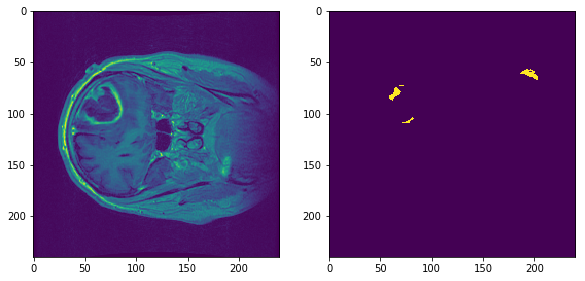

In [169]:
x = 50
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])

### TCGA-06-0240

In [170]:
row = seg_df.iloc[0]
print(row['patient_id'])

TCGA-06-0240


In [171]:
seg_df.head()

,patient_id,seg_loc,seg_file,cohort,patient_exam
0,TCGA-06-0240,/working/lupolab/julia/tcia_analysis/nvidia/ev...,9-AxT1-thin_for_surgery-27598_TC.nii.gz,TCGA-GBM,07-02-2005-04728
1,TCGA-06-0143,/working/lupolab/julia/tcia_analysis/nvidia/ev...,11-COR__T1_POST_GD_FLAIR-28783_TC.nii.gz,TCGA-GBM,02-11-2005-83875
2,TCGA-06-0149,/working/lupolab/julia/tcia_analysis/nvidia/ev...,10-COR_T1_POST_GD_FLAIR-88922_TC.nii.gz,TCGA-GBM,03-25-2003-87536
3,TCGA-19-0955,/working/lupolab/julia/tcia_analysis/nvidia/ev...,8-MRHG_T1_AX_POST_GAD-01973_TC.nii.gz,TCGA-GBM,04-07-2001-NR_MRI_BRAIN_WWO-83151
4,TCGA-06-0648,/working/lupolab/julia/tcia_analysis/nvidia/ev...,11-AX_T1_POST_GD_FLAIR-02197_TC.nii.gz,TCGA-GBM,01-20-2006-51419


In [172]:
PATH

PosixPath('/working/lupolab/julia/tcia_analysis/datasets')

In [173]:
seg_file = row['seg_file']

In [174]:
'_'.join(row['seg_file'].split("_")[:-1])

'9-AxT1-thin_for_surgery-27598'

In [175]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [176]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)


In [177]:
np.where(t2all_vol > 0.5)

(array([64, 64, 64, ..., 88, 88, 88]),
 array([137, 137, 137, ..., 136, 136, 136]),
 array([87, 88, 89, ..., 91, 92, 93]))

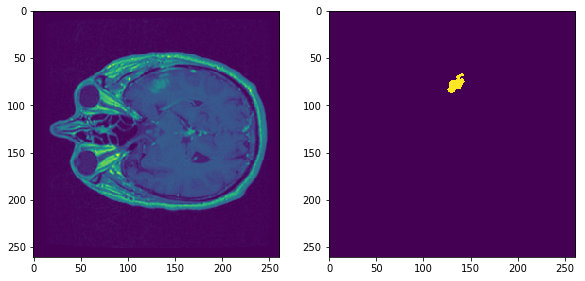

In [178]:
x =85
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])

### TCGA-DU-7309



In [86]:
row = seg_df.iloc[-1]
print(row['patient_id'])

TCGA-DU-7309


In [87]:
seg_file = row['seg_file']

In [88]:
'_'.join(row['seg_file'].split("_")[:-1])

'12-AX_T1_POST_GD_FLAIR-75778'

In [89]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [90]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)


In [94]:
t2all_vol.any()

False

In [91]:
fla_vol.shape[2]/2

100.0

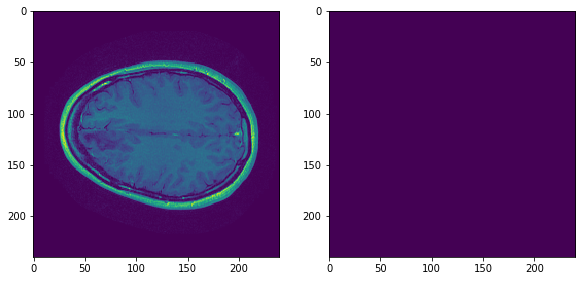

In [92]:
x = 120
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])

### TCGA-DU-A6S6

In [189]:
row = seg_df.iloc[-2]
print(row['patient_id'])

TCGA-DU-A6S6


In [190]:
seg_file = row['seg_file']

In [191]:
'_'.join(row['seg_file'].split("_")[:-1])

'9-COR_T1_POST_GD-46070'

In [192]:
t2all_vol = nib.load(Path(row['seg_loc'],row['seg_file']))
fla_vol = nib.load(Path(PATH, row['cohort']+'-nifti', row['patient_id'], row['patient_exam'], '_'.join(row['seg_file'].split("_")[:-1])+'.nii.gz' ))


In [193]:
fla_vol = np.array(fla_vol.dataobj)
t2all_vol = np.array(t2all_vol.dataobj)


In [194]:
fla_vol.shape[2]/2
t2all_vol.any()

True

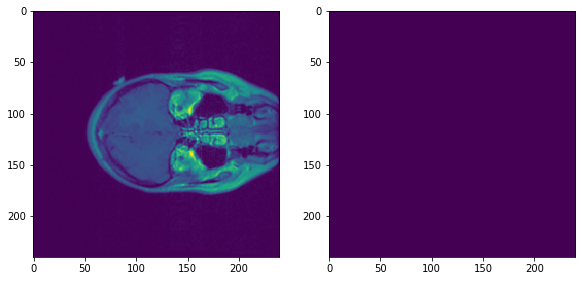

In [198]:
x =50
fig = plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(fla_vol[:,:,x])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(t2all_vol[:,:,x])